In [ ]:
# NB: the recommended way to run isoclassify is through the command-line interface (CLI)
# using examples such as given in examples/examples.csv (see README)
# below is an example to run isoclassify from ipython, which requires some hacking by 
# pre-defining functions but allows direct interaction with posteriors. This will be made 
#

In [47]:
# required packages
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os 
import copy
import glob
import h5py,pdb

import numpy as np
from matplotlib import pylab as plt
import pandas as pd
import ebf
import astropy.units as units
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarWebQuery
import mwdust

from isoclassify.direct import classify as classify_direct
from isoclassify.grid import classify as classify_grid
from isoclassify import DATADIR

In [48]:
# load models
model = ebf.read(os.path.join(DATADIR,'mesa.ebf'))
model['rho'] = np.log10(model['rho'])
# next line turns off Dnu scaling relation corrections
model['fdnu'][:]=1.
model['avs']=np.zeros(len(model['teff']))
model['dis']=np.zeros(len(model['teff']))

In [49]:
# define class that contains observables
x = classify_grid.obsdata()

In [50]:
# add [Teff, logg, FeH] and [sigma_Teff, sigma_logg, sigma_FeH] 
x.addspec([5777.,4.44,0.0],[60.,0.07,0.04])

teff 137568
feh 14638
number of models used within non-phot obsconstraints: 14638
number of models after phot constraints: 14638
----
teff 5769.9830329184015 59.301879620967156 61.19188713935091
logg 4.440011434041236 0.04939213673305343 0.06246456105140474
feh -0.025556720071448456 0.04454931676284045 0.045047446227463046
rad 0.9821114262857732 0.06629016614236216 0.048303954497392776
mass 0.9798198517293614 0.029181390650679373 0.03231265334395139
rho 1.0169041692481189 0.18190202144832757 0.190798725519854
lum 0.9652321348100994 0.14624805649003925 0.11097964501746693
age 4.379363252857259 2.7292234390562555 2.611800626530722


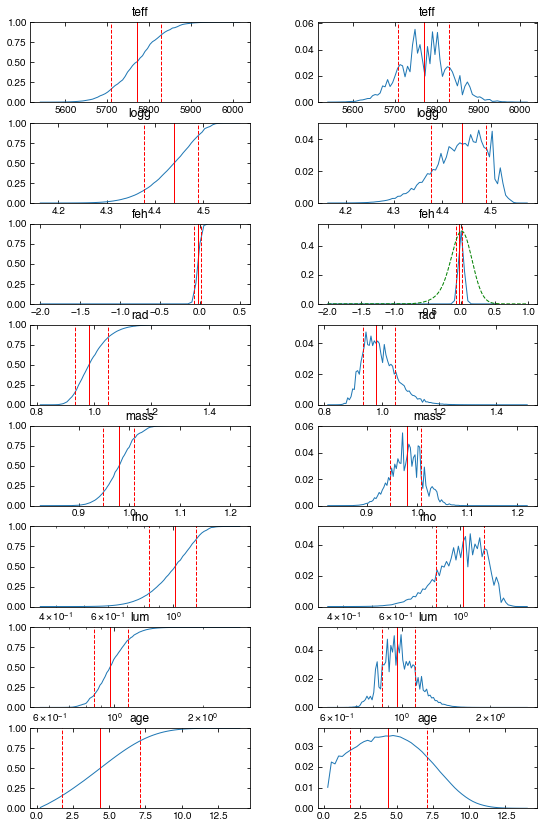

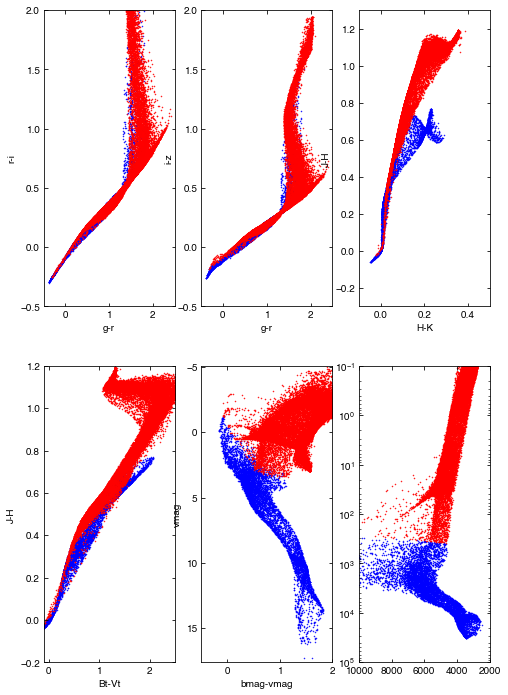

In [27]:
# perform classification based on those inputs
paras = classify_grid.classify(input=x, model=model, dustmodel=0,plot=1)

In [57]:
# print results for radius
paras.rad,paras.radep,paras.radem

(1.0028057636419216, 0.058511431856871354, 0.05040759353350621)

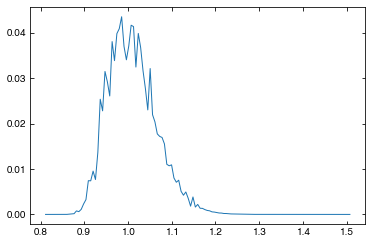

In [58]:
# plot the radius posterior
plt.plot(paras.radpx,paras.radpy)

In [59]:
# now let's add some more observables, e.g. a parallax 
x.addplx(0.07,0.007)

In [60]:
# and some JHK photometry
x.addjhk([4.38,4.04,4.00],[0.03,0.03,0.03])

In [61]:
# using photometry requires some treatment of reddening and extinction. the following functions
# required for this

def query_dustmodel_coords(ra,dec):
    reddenMap = BayestarWebQuery(version='bayestar2017')
    sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='icrs')
    reddenContainer = reddenMap(sightLines,mode='best')
    del reddenMap # To clear reddenMap from memory
    distanceSamples = np.array([0.06309573,0.07943284,0.1,0.12589255,0.15848933,0.19952627,0.25118864,0.31622776,0.3981072,0.50118726,0.6309574,0.7943282 ,1.,1.2589258,1.5848933,1.9952621,2.511887,3.1622777,3.981073,5.011873,6.3095727,7.943284,10.,12.589258,15.848933,19.952621,25.11887,31.622776,39.81073,50.11873,63.095726])*1000. # In pc, from bayestar2017 map distance samples
    
    dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})

    for index in xrange(len(reddenContainer)):
        dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]
        
    return dustModelDF
    
def query_dustmodel_coords_allsky(ra,dec):
    reddenMap = mwdust.Combined15()
    sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='galactic')
    distanceSamples = np.array([0.06309573,0.07943284,0.1,0.12589255,0.15848933,0.19952627,0.25118864,0.31622776,0.3981072,0.50118726,0.6309574,0.7943282 ,1.,1.2589258,1.5848933,1.9952621,2.511887,3.1622777,3.981073,5.011873,6.3095727,7.943284,10.,12.589258,15.848933,19.952621,25.11887,31.622776,39.81073,50.11873,63.095726])*1000. # In pc, from bayestar2017 map distance samples
    reddenContainer=reddenMap(sightLines.l.value,sightLines.b.value,distanceSamples/1000.)
    del reddenMap # To clear reddenMap from memory
    
    dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})
    
    for index in xrange(len(reddenContainer)):
        dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]

    return dustModelDF

def extinction(law):
    if (law == 'cardelli'):
        out = {
            "ab":4.1708789, 
            "av":3.1071930, 
            "abt":4.3358221, 
            "avt":3.2867038, 
            "ag":3.8281101, 
            "ar":2.7386468, 
            "ai":2.1109662, 
            "az":1.4975613, 
            "aj":0.89326176, 
            "ah":0.56273418, 
            "ak":0.35666104, 
            "aga":2.4623915
        }
        
    if (law == 'schlafly11'):
        out = {
            "ab":3.626, 
            "av":2.742, 
            "abt":4.5309214, 
            "avt":3.1026801, 
            "ag":3.303, 
            "ar":2.285, 
            "ai":1.698, 
            "az":1.263, 
            "aj":0.77510388, 
            "ah":0.50818384, 
            "ak":0.33957048, 
            "aga":1.9139634
        }

    if (law == 'schlafly16'):
        # see http://argonaut.skymaps.info/usage under "Gray Component". this is a lower limit.
        grayoffset=0.063
        out = {
            "ab":3.6060565+grayoffset, 
            "av":2.9197679+grayoffset, 
            "abt":3.7204173+grayoffset, 
            "avt":3.0353634+grayoffset, 
            "ag":3.384+grayoffset, 
            "ar":2.483+grayoffset, 
            "ai":1.838+grayoffset, 
            "az":1.414+grayoffset, 
            "aj":0.650+grayoffset, 
            "ah":0.327+grayoffset, 
            "ak":0.161+grayoffset, 
            "aga":2.2203186+grayoffset
        }
    return out


In [62]:
# if we don't want to use a reddening map, isoclassify fits for Av. However, we need to 
# define an extinction law
ext = extinction('cardelli')

teff 137568
feh 14638
number of models used within non-phot obsconstraints: 14638
number of models incl reddening: 1902940
number of models after phot constraints: 1902919
----
teff 5782.511264740671 55.36909842633031 61.17511857885984
logg 4.422420336073602 0.05072725294959035 0.054462391467733795
feh -0.022730092155238232 0.04549299264764489 0.043311970094012706
rad 1.0028057636419216 0.058511431856871354 0.05040759353350621
mass 0.9801957431244573 0.03194358673363362 0.03251186355207991
rho 0.9582776756886522 0.16826866207377233 0.16115764620669804
lum 1.0084269686879728 0.13901170133374485 0.10743980966584954
age 4.967266996317461 2.4225342331381814 2.556057333238361
avs 0.08695089942986776 0.30588051473559885 0.24810844575797186
dis 13.782725429944524 0.8247326506017139 0.6907897692336942


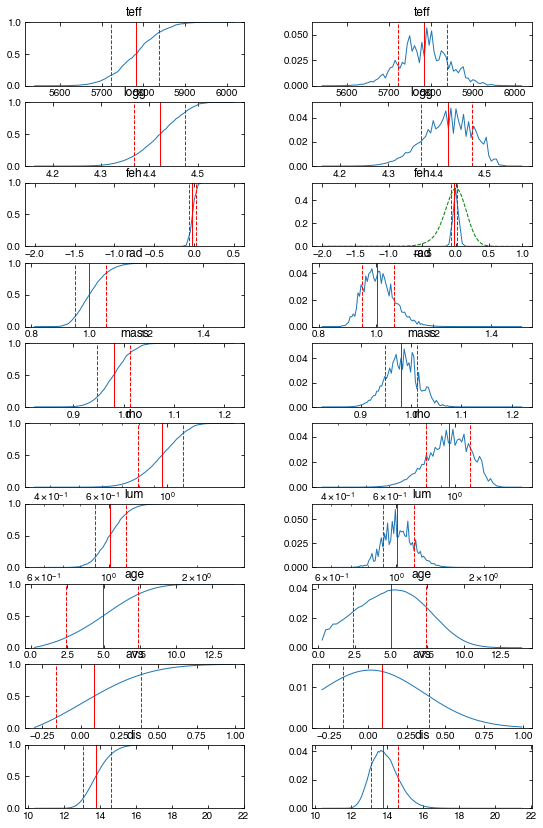

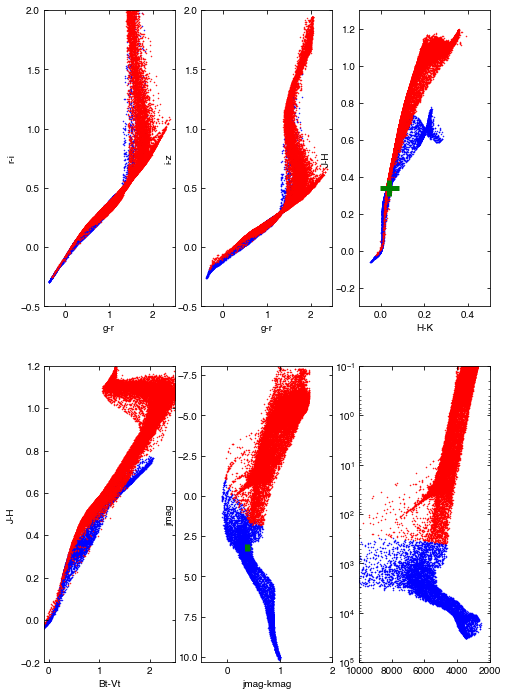

In [63]:
# perform classification
paras = classify_grid.classify(input=x, model=model, dustmodel=0,plot=1,ext=ext)

In [64]:
# if we want to use a reddening map, we'll need to add coordinates
x.addcoords(243.9052932171665,-08.3694394)

In [65]:
# and define a dustmodel. this is the "allsky" model by Bovy
dustmodel = query_dustmodel_coords_allsky(x.ra,x.dec)

teff 137568
feh 14638
number of models used within non-phot obsconstraints: 14638
number of models incl reddening: 14638
number of models after phot constraints: 14638
----
teff 5778.093008700378 54.03993021423412 61.11296081614546
logg 4.424183894958253 0.049751352258194714 0.054639531611869074
feh -0.023146547280594534 0.04536108415395512 0.04358489257691983
rad 0.999713380606912 0.05859214991267325 0.04939917279037764
mass 0.9787461246937781 0.03041570851142117 0.032307616975860265
rho 0.9641010300914233 0.17264474956113351 0.16075052285542746
lum 0.9980278368964101 0.13632431562435154 0.10437860304938662
age 4.983784928926623 2.4462174825637693 2.576545150207149
avs 0.003411695853225472 0.00020099547431344034 0.00017503181935344184
dis 13.831190506131108 0.8183801463973168 0.7056002986766536


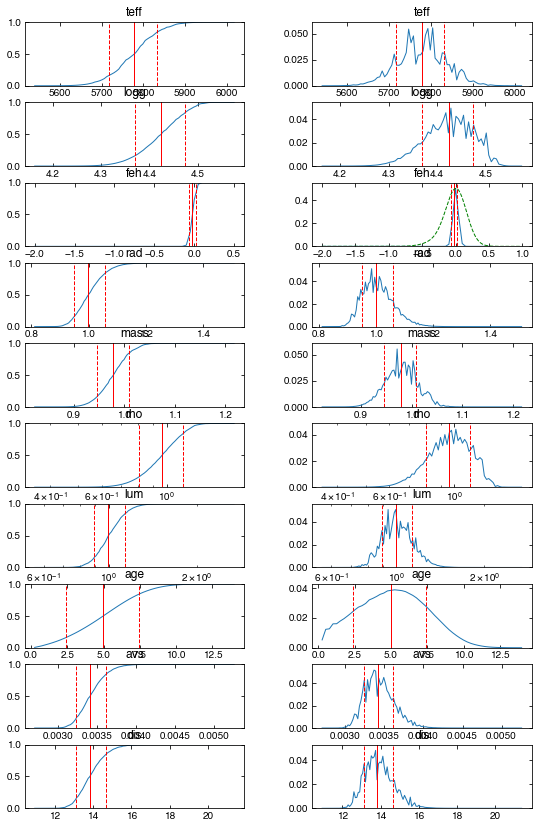

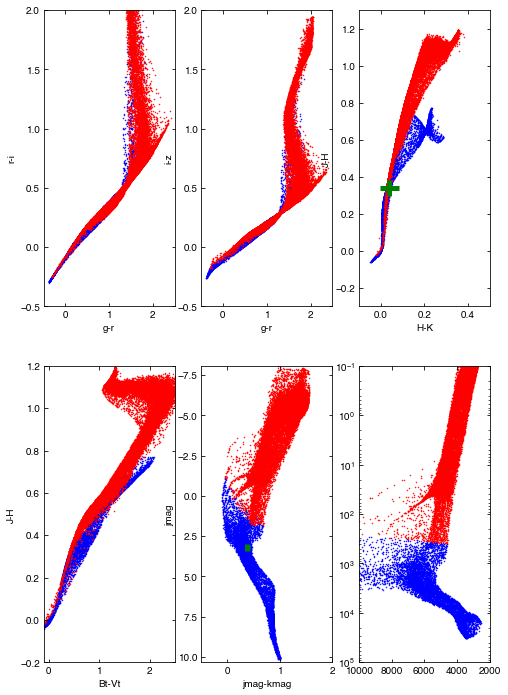

In [66]:
# redo fit, this time using the dustmodel
paras = classify_grid.classify(input=x, model=model, dustmodel=dustmodel,plot=1,ext=ext)